In [1]:
import numpy as np
from pathlib import Path
from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt
import sys 
import jax
from datasets import nbody_dataset 
sys.path.append("../")

2023-11-24 15:04:05.140699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/extras/CUPTI/lib64:/n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/lib64:/n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/lib:/n/sw/helmod-rocky8/apps/Core/gcc/12.2.0-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/gcc/12.2.0-fasrc01/lib:/n/sw/helmod-rocky8/apps/Core/mpc/1.3.1-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/mpfr/4.2.0-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/gmp/6.2.1-fasrc01/lib64
2023-11-24 15:04:10.105203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/sw/helmod-rock

In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = plt.cm.get_cmap('viridis_r')
#cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [5]:
boxsize = 1000.
r_bins = np.linspace(0.5, 150.0, 25)
k_values = [1,5,9]
r_c = 0.5*(r_bins[1:] + r_bins[:-1])
mu_bins = np.linspace(-1, 1, 201)
n = 50 

data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/')
test_halos = np.load(data_dir / 'test_halos_fiducial.npy')[:n,:,:]
test_halos[...,-1] = np.log10(test_halos[...,-1])

In [6]:
def get_tpcf(pos,):
    return TwoPointCorrelationFunction(
                "smu",
                edges=(np.array(r_bins), np.array(mu_bins)),
                data_positions1=pos.T,
                engine="corrfunc",
                n_threads=2,
                boxsize=boxsize,
                los="z",
    )(ells=[0])[0]

In [7]:
def get_samples_across_checkpoints(path_to_samples, checkpoints):
    generated_samples = []
    for checkpoint in checkpoints:
        generated_samples.append(np.load(path_to_samples / f'fiducial_samples_steps500_checkpoint{checkpoint}.npy')[:n])
    return generated_samples

In [8]:
gnn_pos = 'gallant-cherry-87'
transformer_vel = 'magical-goosebump-109'
n_test = len(test_halos)
path_to_data = Path(f'/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/set_diffuser/samples/')
checkpoints = list(np.arange(5000, 305_000, 10_000)) 
gnn_pos_samples = get_samples_across_checkpoints(
    path_to_data / f'{gnn_pos}', checkpoints,
)
transformer_vel_samples = get_samples_across_checkpoints(
    path_to_data / f'{transformer_vel}', checkpoints,
)



In [9]:
def get_gen_tpcfs(generated_samples):
    test_gen_tpcfs = []
    for samples in generated_samples:
        tpcfs = []
        for hpos in samples:
            tpcfs.append(
                get_tpcf(np.array(hpos[...,:3]))
            )
        test_gen_tpcfs.append(tpcfs)
    return np.array(test_gen_tpcfs)

In [10]:
# compute 2pcfs
test_tpcfs = []
for hpos in test_halos:
    test_tpcfs.append(
        get_tpcf(hpos[...,:3])
    )
test_tpcfs = np.array(test_tpcfs)
gnn_pos_tpcfs =get_gen_tpcfs(gnn_pos_samples) 
transformer_vel_tpcfs =get_gen_tpcfs(transformer_vel_samples) 


In [11]:

import jax.numpy as jnp
from jax.scipy.linalg import inv, det

def kl_divergence_gaussian(samples_P, samples_Q, lambda_reg=1.e-6,):
    """
    Compute KL divergence between two multivariate Gaussians using samples.

    Args:
        samples_P, samples_Q: Samples from distributions P and Q. Each should be 
        a 2D array with shape [num_samples, dimensionality].

    Returns:
        KL divergence between the Gaussians estimated from the samples.
    """
    mu_P = jnp.mean(samples_P, axis=0)
    mu_Q = jnp.mean(samples_Q, axis=0)
    
    Sigma_P = jnp.cov(samples_P.T)  + lambda_reg * jnp.eye(mu_P.shape[0])
    Sigma_Q = jnp.cov(samples_Q.T) + lambda_reg * jnp.eye(mu_Q.shape[0])
    inv_Sigma_Q = inv(Sigma_Q)
    
    delta_mu = mu_Q - mu_P

    term1 = jnp.trace(jnp.dot(inv_Sigma_Q, Sigma_P))
    term2 = jnp.dot(delta_mu.T, jnp.dot(inv_Sigma_Q, delta_mu))
    term3 = jnp.log(det(Sigma_Q) / det(Sigma_P))
    
    k = mu_P.shape[0]  # dimensionality

    kl_div = 0.5 * (term1 + term2 - k + term3)
    return kl_div

def get_kl(true, sampled, r_max=55.):
    kl_divergence = []
    for i, sample in enumerate(sampled):
        kl_divergence.append(kl_divergence_gaussian(true[:,r_c < r_max], sample[:,r_c < r_max])) 
    return np.array(kl_divergence)

kl_gnn_pos = get_kl(test_tpcfs, gnn_pos_tpcfs)
kl_transformer_vel = get_kl(test_tpcfs, transformer_vel_tpcfs)

I0000 00:00:1700856362.374177 2493930 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


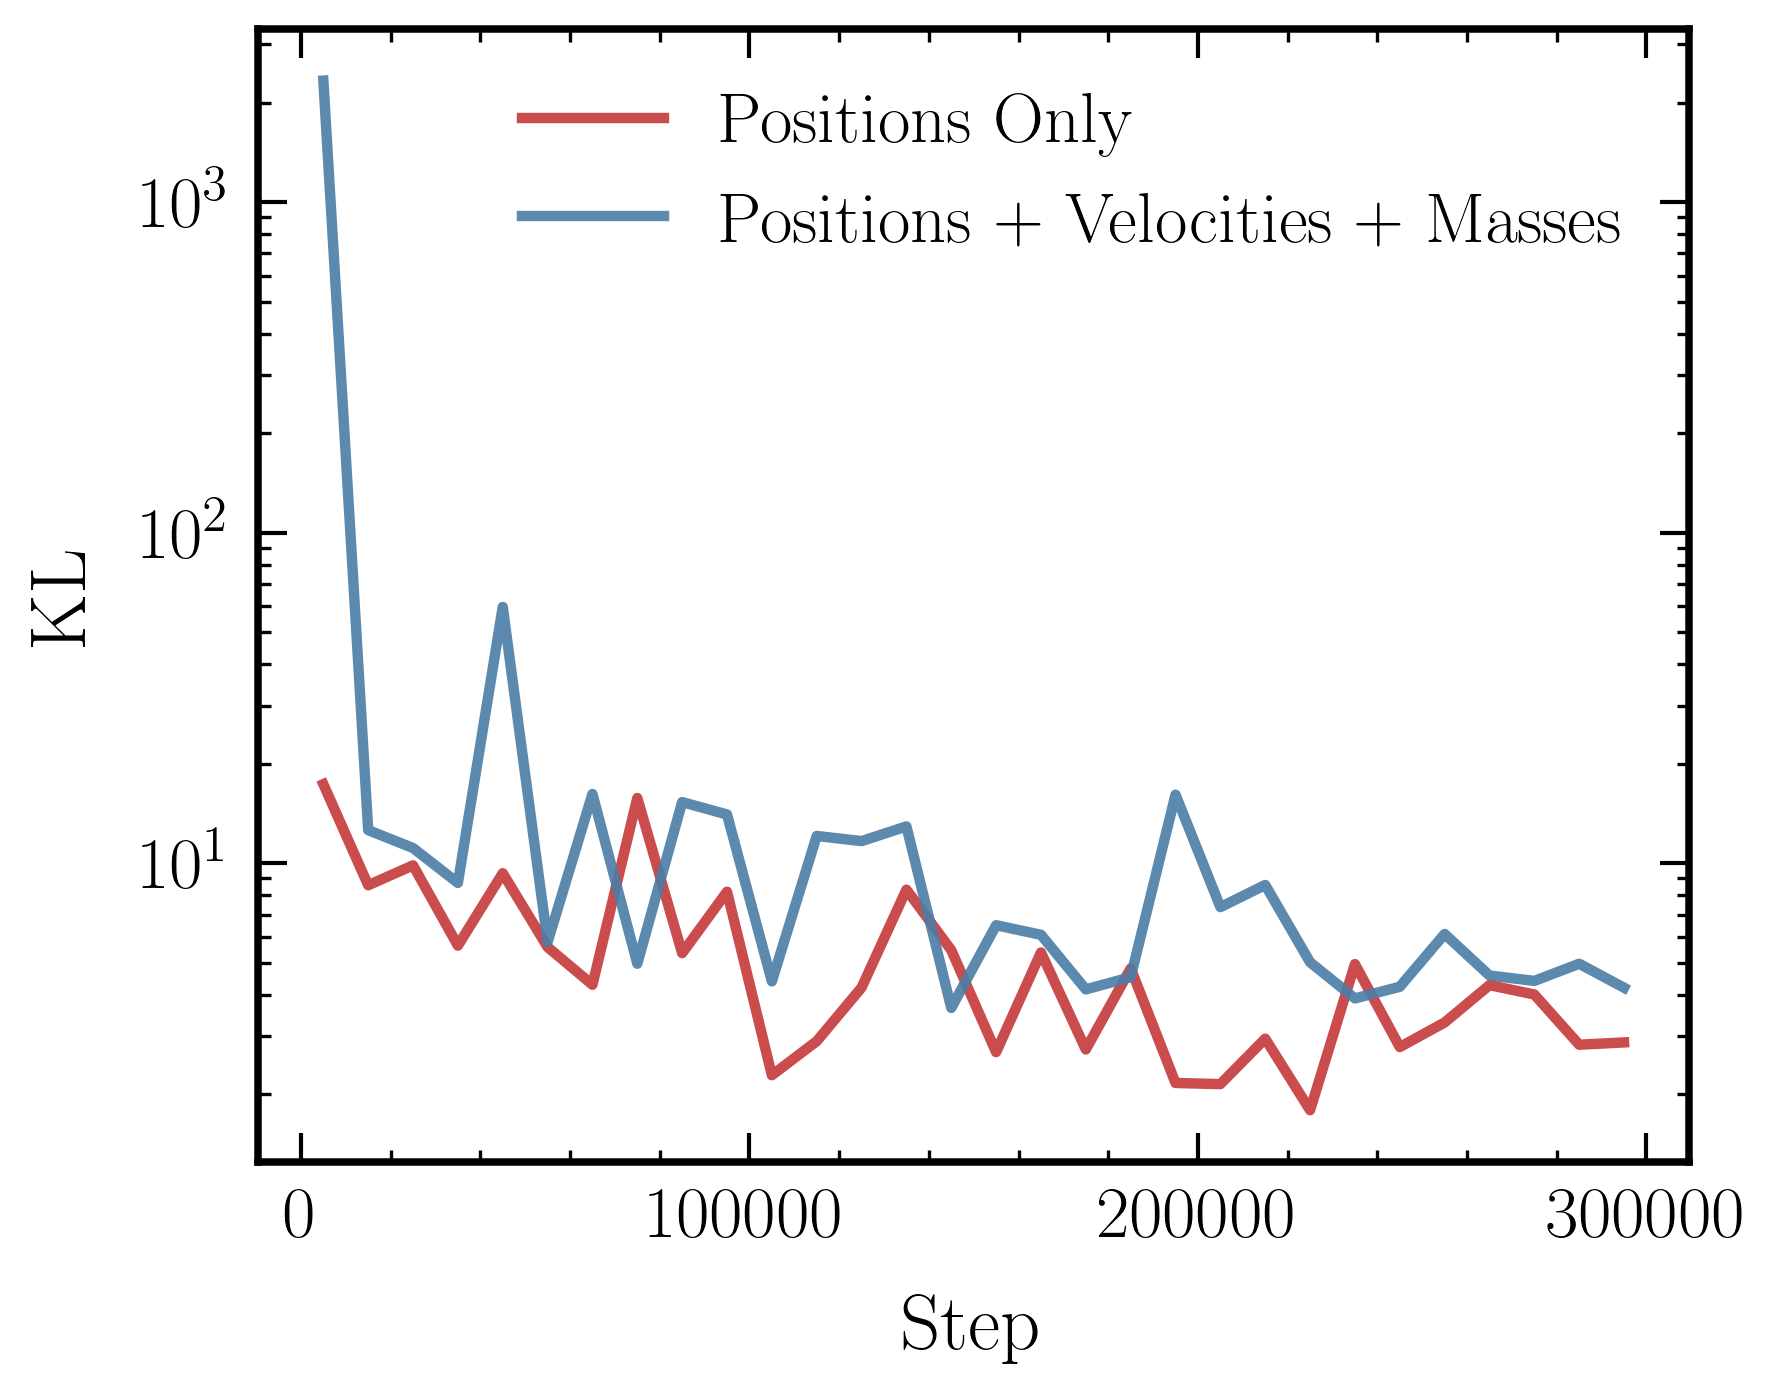

In [12]:
plt.plot(checkpoints, kl_gnn_pos, label='Positions Only')
plt.plot(checkpoints, kl_transformer_vel, label='Positions + Velocities + Masses')
plt.xlabel('Step')
plt.ylabel('KL')
plt.legend()
plt.yscale('log')

In [13]:

from models.diffusion import VariationalDiffusionModel

In [14]:
def get_norm_dict(n_features):
    _, norm_dict = nbody_dataset(
        n_features=n_features,
        n_particles=5_000,
        split="test",
        batch_size=1,
        seed=1,
    )
    return norm_dict

rng = jax.random.PRNGKey(42)
n_steps = 500


norm_dict_pos = get_norm_dict(3)
norm_dict = get_norm_dict(7)


2023-11-24 15:06:17.650011: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/extras/CUPTI/lib64:/n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/lib64:/n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/lib:/n/sw/helmod-rocky8/apps/Core/gcc/12.2.0-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/gcc/12.2.0-fasrc01/lib:/n/sw/helmod-rocky8/apps/Core/mpc/1.3.1-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/mpfr/4.2.0-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/gmp/6.2.1-fasrc01/lib64
2023-11-24 15:06:17.652576: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/sw/helmod-rock

In [15]:

def get_loss_for_model(run_name, test_halos, norm_dict, path_to_models,):
    path_to_model = path_to_models / run_name
    fiducial_cosmology = np.array([0.3175, 0.834])
    fiducial_cosmologies = np.repeat(fiducial_cosmology[None, :], len(test_halos), axis=0)
    test_halos_fiducial = (test_halos - norm_dict['mean']) / norm_dict['std']
    loss = []
    for checkpoint in checkpoints:
        vdm, params = VariationalDiffusionModel.from_path_to_model(
            path_to_model=path_to_model,
            checkpoint_step=checkpoint,
        )
        loss_diff, loss_klz, loss_recon = vdm.apply(
                params,
                test_halos_fiducial,
                fiducial_cosmologies,
                np.ones_like(test_halos_fiducial[..., 0]),
                rngs={'sample':rng},
            )
        l = (loss_diff.sum((-1)) + loss_klz.sum((-1)) + loss_recon.sum((-1))).mean()
        loss.append(l)
    return loss

In [16]:
del gnn_pos_samples
del transformer_vel_samples 

In [17]:
path_to_models = Path(
    f"/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/"
)
loss_pos = get_loss_for_model(gnn_pos, test_halos[...,:3], norm_dict_pos, path_to_models)

In [18]:

loss_vel = get_loss_for_model(transformer_vel, test_halos[:10], norm_dict, path_to_models)

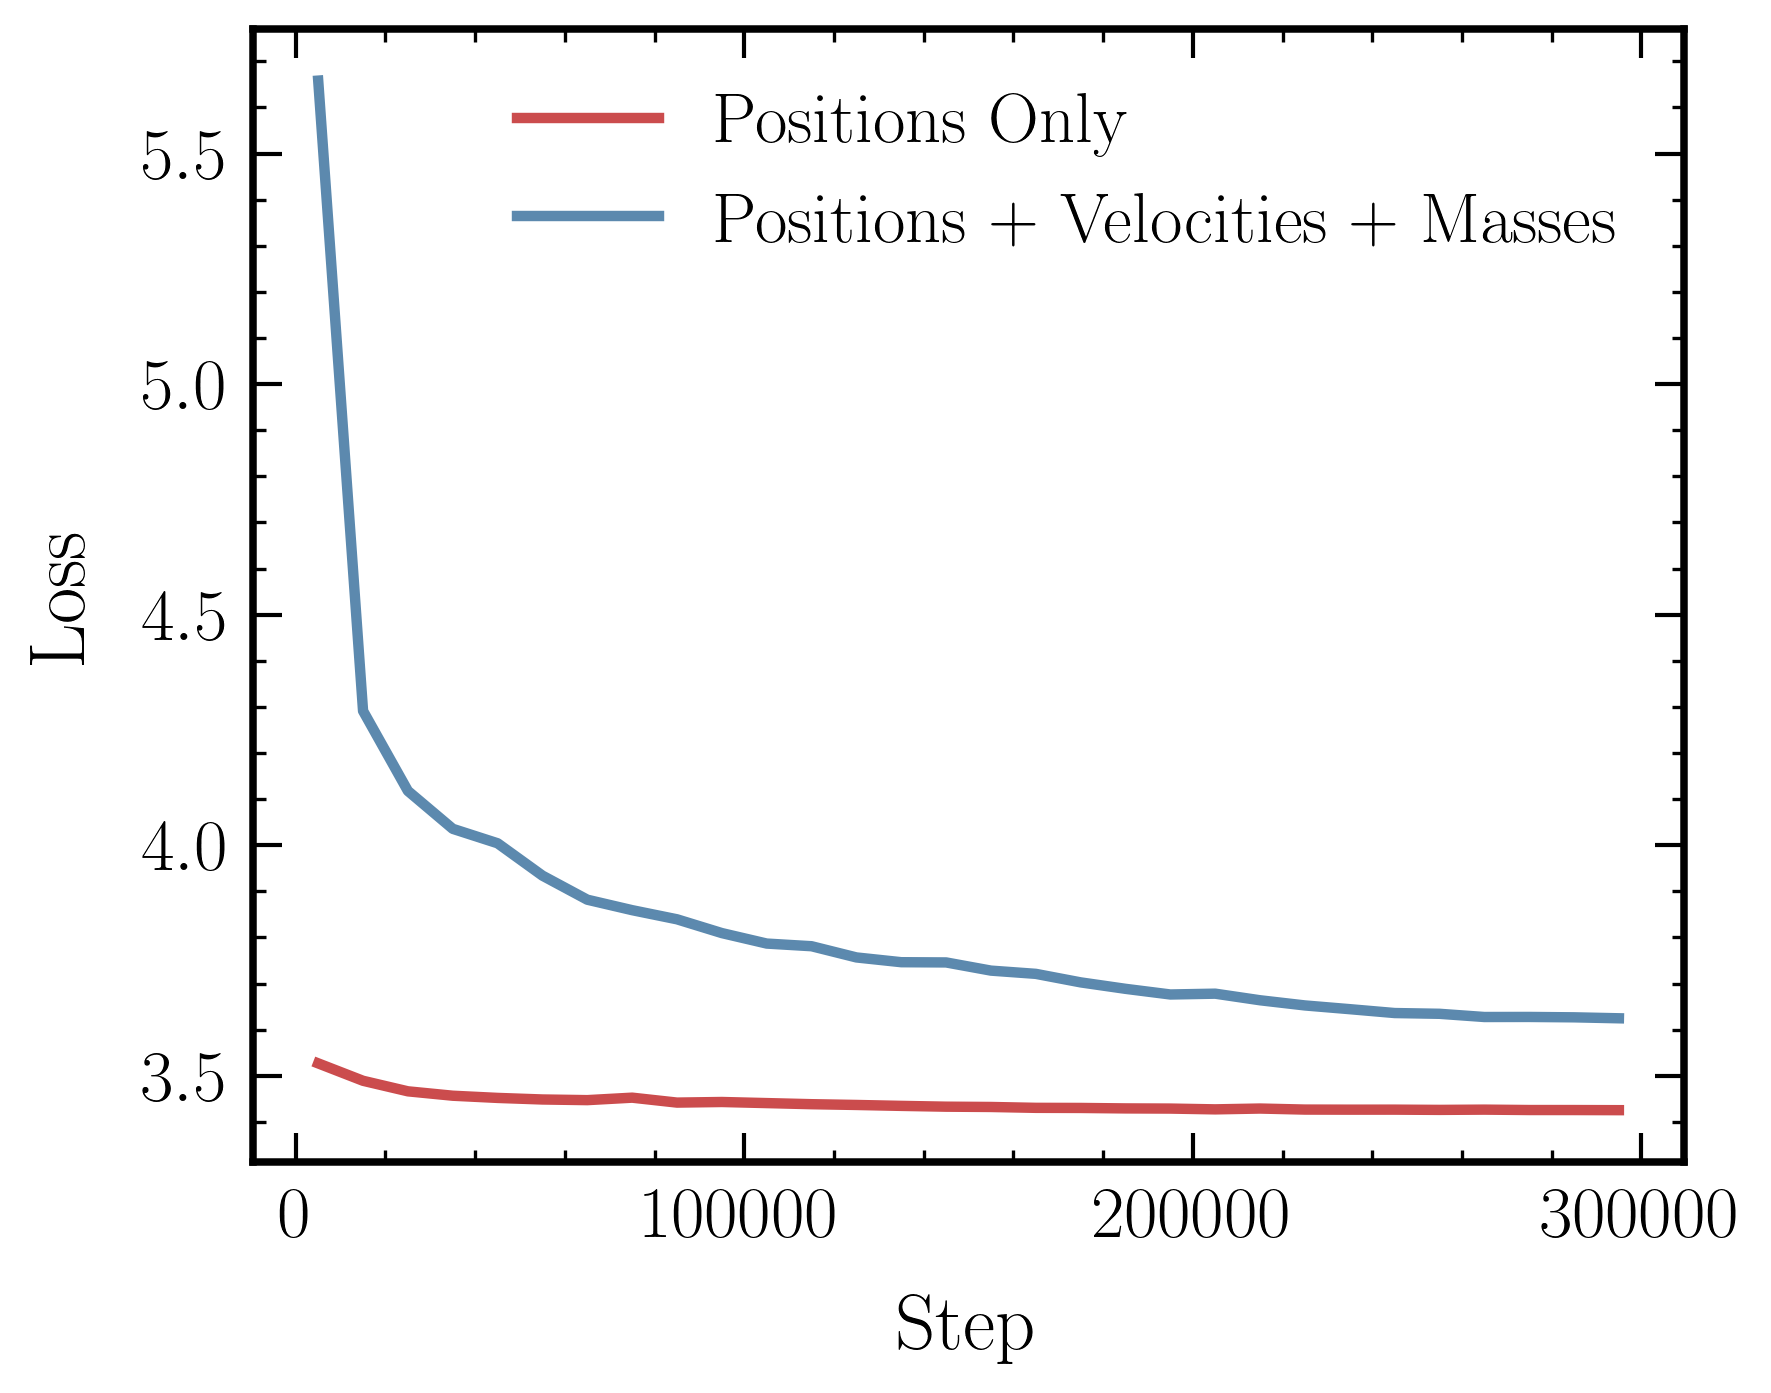

In [19]:
plt.plot(checkpoints, loss_pos, label='Positions Only')
plt.plot(checkpoints, loss_vel, label='Positions + Velocities + Masses')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

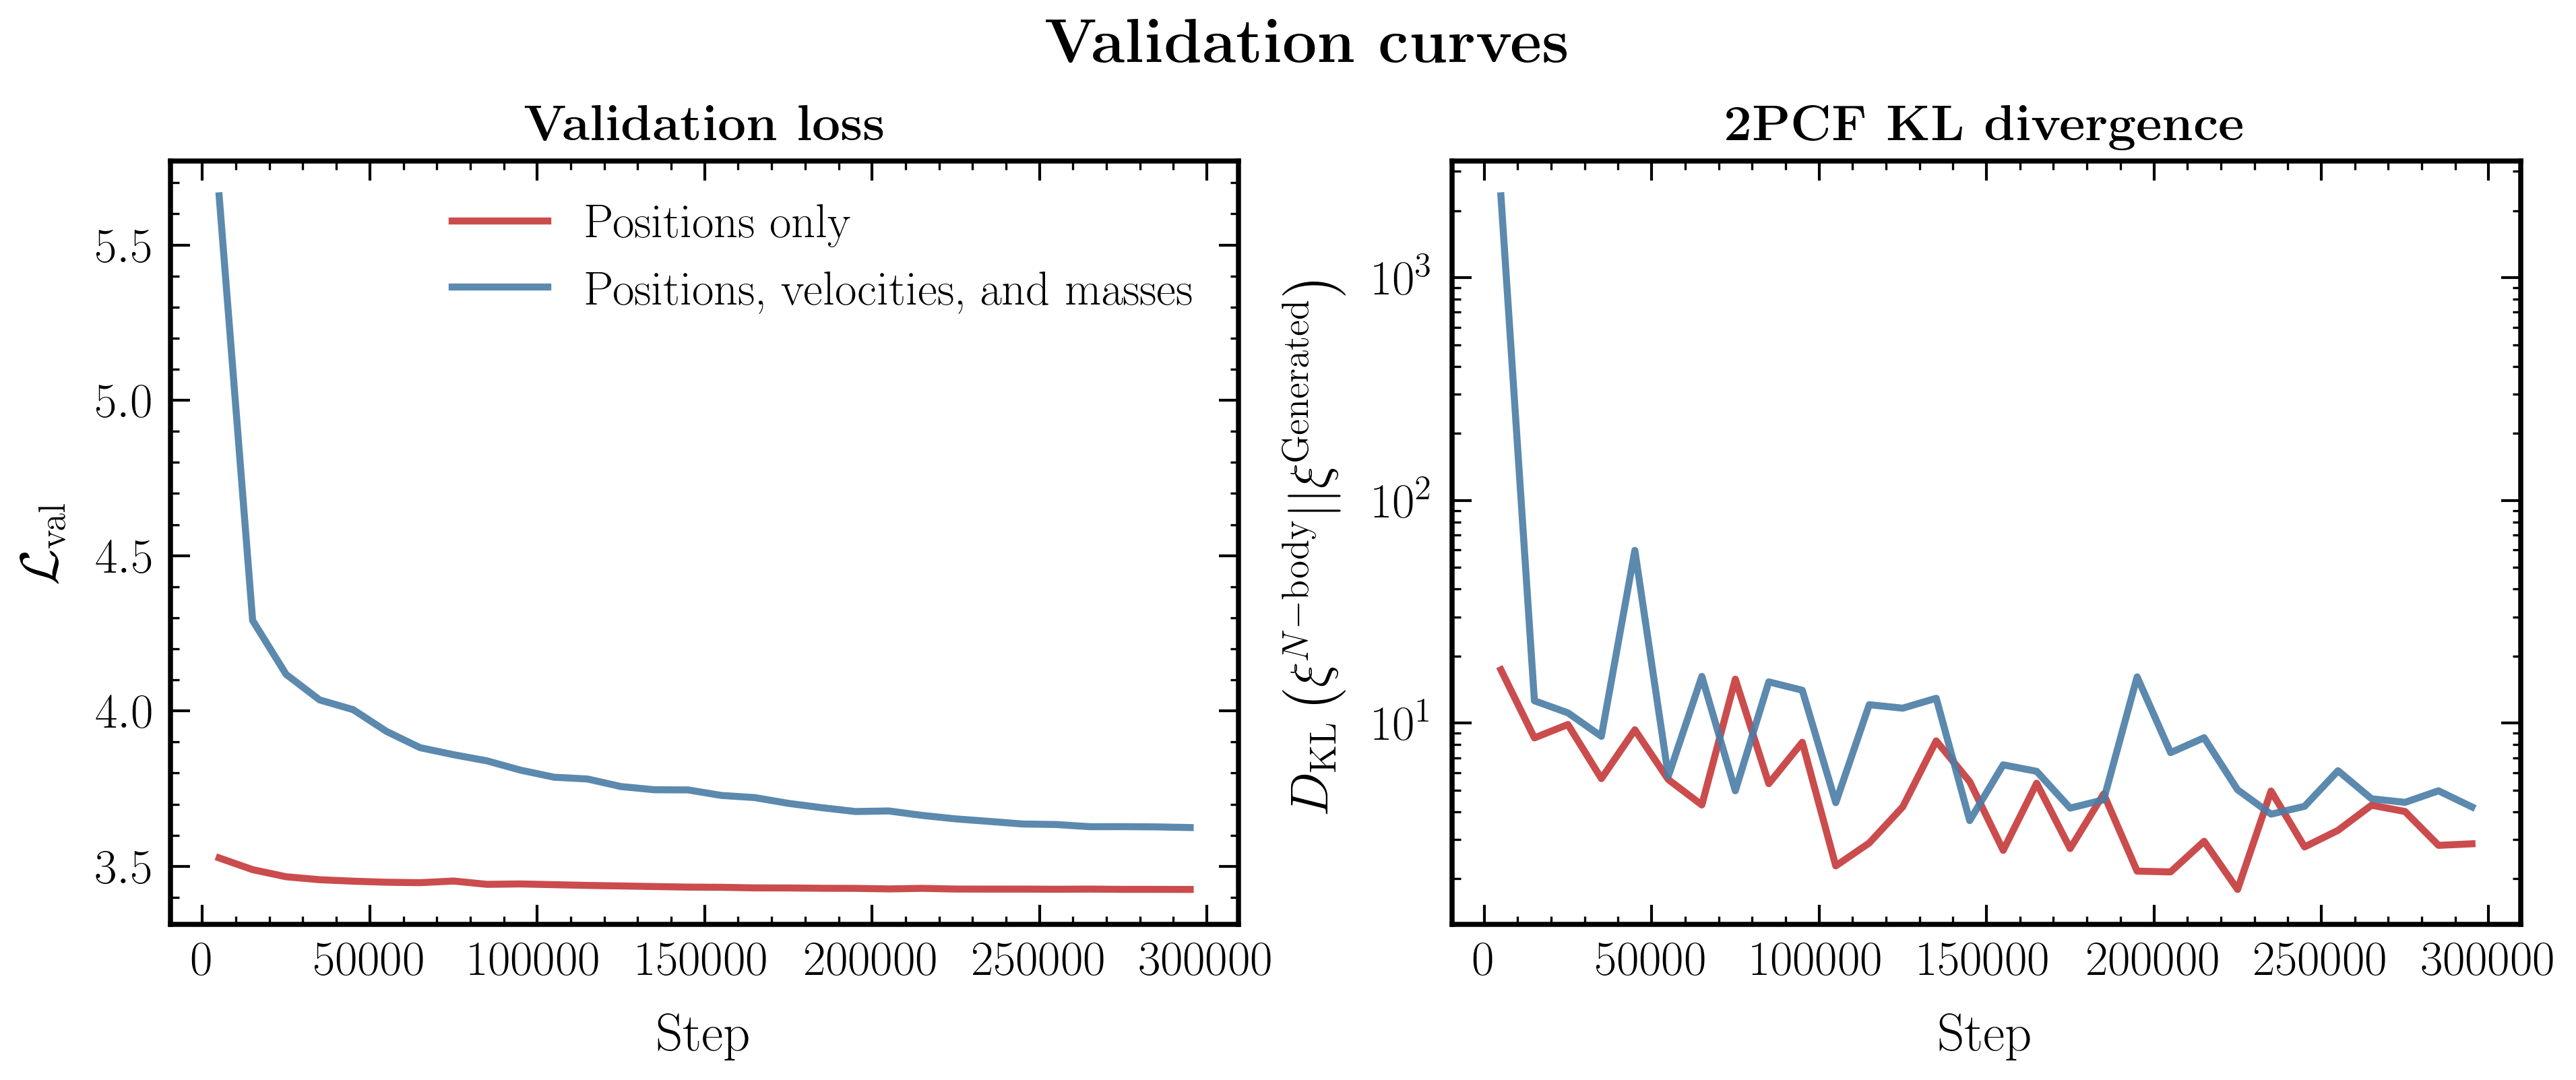

In [28]:
fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(15,5))

ax[0].plot(checkpoints, loss_pos, label='Positions only')
ax[0].plot(checkpoints, loss_vel, label='Positions, velocities, and masses')
ax[0].set_xlabel('Step')
ax[0].set_ylabel(r'$\mathcal L_{\rm val}$')
ax[0].legend()


ax[1].plot(checkpoints, kl_gnn_pos, label='Positions Only')
ax[1].plot(checkpoints, kl_transformer_vel, label='Positions + Velocities + Masses')
ax[1].set_xlabel('Step')
ax[1].set_ylabel(r'$D_{\rm KL}\left(\xi^{N\mathrm{-body}}||\xi^\mathrm{Generated}\right)$')
ax[1].set_yscale('log')

ax[0].set_title(r"\bf{Validation loss}", fontsize=18)
ax[1].set_title(r"\bf{2PCF KL divergence}", fontsize=18)
plt.suptitle(r"\bf{Validation curves}", fontsize=22, y=1.02)
plt.savefig('plots/training_dynamics.pdf', bbox_inches='tight', )